In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# A bandit gives a random reward from a particular Gaussian distribution.
class Bandit:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def sample(self):
        return np.random.normal(self.mean, self.std)

In [3]:
class MultiArmedBandit:
    def __init__(self, num_arms=2, means=None, stds=1):
        if means is None:
            self.means = np.random.uniform(0, 5, num_arms)
        else:
            self.means = means
        if stds is None:
            self.stds = np.random.uniform(0, 3, num_arms)
        else:
            self.stds = stds
        self.bandits = [Bandit(mean, std) for mean, std in zip(self.means, self.stds)]
        self.arms_pulled = np.zeros(num_arms, dtype=int)
        self.arms_rewards = np.zeros(num_arms)
        self.arms_rewards_avg = np.zeros(num_arms)
        self.num_arms = num_arms
        self.actions = np.arange(0, num_arms)
        self.epsilon_strategy_used = 0
        
        self.optimal_action = np.argmax(self.means)
        self.optimal_action_reward = np.max(self.means)
        self.regrets = []
        
        self.lai_robbins_values = []
        
        
    def reset(self):
        self.__init__(self.num_arms, self.means, self.stds)
        
    def get_greedy_action(self):
        return np.argmax(self.arms_rewards_avg)
    
    def get_ucb_action(self, c):
        t = np.sum(self.arms_pulled)
        uncertainty_values = []
        for val in self.arms_pulled:
            if val == 0:
                uncertainty_values.append(float('inf'))
            else:
                uncertainty_values.append(c*np.sqrt(np.log(t)/val))
        return np.argmax(np.array(uncertainty_values))
        
        
    def action_selection(self, strategy="epsilon_greedy", eps=None, c=None):
        selected_action = None
        
        if strategy == "epsilon_greedy":
            assert eps is not None
            greedy_prob = eps + 1.0*(1-eps)/self.num_arms
            action_probs = [(1-greedy_prob)/self.num_arms]*self.num_arms
            action_probs[self.get_greedy_action()] = greedy_prob
            action_probs[-1] += 1.0 - np.sum(action_probs)
            
            selected_action = np.random.choice(self.actions, p=action_probs)
            if selected_action == self.get_greedy_action():
                self.epsilon_strategy_used += 1
        elif strategy == "ucb":
            assert c is not None
            selected_action = self.get_ucb_action(c)
    
        return selected_action
    
    def calculate_lai_robbins_value(self):
        t = np.sum(self.arms_pulled)
        
        lai_robbins_value = 0.0
        for i, mean in enumerate(self.means):
            if i != self.optimal_action:
                diff = self.optimal_action_reward - mean
                kl_div = np.log(self.stds[self.optimal_action]/self.stds[i]) + (self.stds[i]**2 + (mean - self.optimal_action_reward)**2)/(2*(self.stds[self.optimal_action]**2)) - 0.5
                
                lai_robbins_value += (diff/kl_div)
        lai_robbins_value *= np.log(t)
        self.lai_robbins_values.append(lai_robbins_value)
        return lai_robbins_value
            
        
    def sample(self, action):
        reward = self.bandits[action].sample()
        self.arms_pulled[action] += 1
        self.arms_rewards[action] += reward
        self.arms_rewards_avg[action] = 1.0*self.arms_rewards[action]/self.arms_pulled[action]
        
        self.regrets.append(self.optimal_action_reward - self.arms_rewards_avg[action])
        
        self.calculate_lai_robbins_value()
        return reward
    
    def get_state(self):
        return self.arms_rewards, self.arms_pulled, self.arms_rewards_avg
    
    def get_regret_cumsum(self):
        return np.cumsum(self.regrets)
    
    def get_lai_robbins_values(self):
        return self.lai_robbins_values

## Epsilon greedy approach

In [4]:
num_arms = 5
means = np.random.uniform(0, 6, num_arms) 
stds = [1]*num_arms
num_experiments = 100
num_iterations = 1000

strategy="epsilon_greedy"
eps_values = 0.5 + 0.1 * np.arange(0, 5)

expected_regret_cumsum_values = dict()
expected_lai_robbins_values = dict()
correct_arms_pulled = dict()

multi_bandit = MultiArmedBandit(num_arms=num_arms, means=means, stds=stds)

for eps in eps_values:
    all_exps_regret_cumsum = []
    all_exps_lai_robbins = []
    all_exps_correct_arms_pulled = []
    for num_exp in range(1, num_experiments+1):
        for i in range(num_iterations):
            multi_bandit.sample(multi_bandit.action_selection(strategy=strategy, eps=eps))

        all_exps_regret_cumsum.append(multi_bandit.get_regret_cumsum())
        all_exps_lai_robbins.append(multi_bandit.get_lai_robbins_values())
        
        all_exps_correct_arms_pulled.append(round(
            100.0*multi_bandit.arms_pulled[multi_bandit.optimal_action]/num_iterations, 2))
        multi_bandit.reset()
        
    all_exps_regret_cumsum = np.array(all_exps_regret_cumsum)
    all_exps_lai_robbins = np.array(all_exps_lai_robbins)
    
    expected_regret_cumsum_values[eps] = np.mean(all_exps_regret_cumsum, axis=0)
    expected_lai_robbins_values[eps] = np.mean(all_exps_lai_robbins, axis=0)
    correct_arms_pulled[eps] = np.mean(all_exps_correct_arms_pulled)

In [5]:
with open('epsilon-greedy_regret.pkl', 'wb') as f:
    pickle.dump(expected_regret_cumsum_values, f)

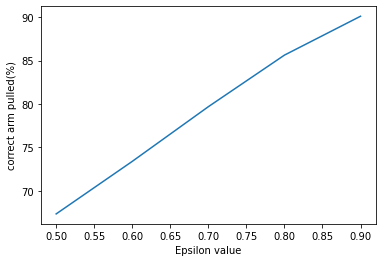

In [6]:
keys, values = correct_arms_pulled.keys(), correct_arms_pulled.values()
plt.plot(keys, values)
plt.xlabel("Epsilon value")
plt.ylabel("correct arm pulled(%)")
plt.savefig("eps-vs-correct_arm_pulled.jpg", dpi=500)

## UCB approach

In [7]:
num_arms = 5
means = np.random.uniform(0, 6, num_arms) 
stds = [1]*num_arms
num_experiments = 100
num_iterations = 1000

strategy="ucb"
c_values = [2.0, 3.0, 5.0, 8.0, 10.0]

expected_regret_cumsum_values_ucb = dict()
correct_arms_pulled_ucb = dict()

multi_bandit = MultiArmedBandit(num_arms=num_arms, means=means, stds=stds)

for c in c_values:
    all_exps_regret_cumsum = []
    all_exps_correct_arms_pulled = []
    for num_exp in range(1, num_experiments+1):
        for i in range(num_iterations):
            multi_bandit.sample(multi_bandit.action_selection(strategy=strategy, c=c))

        all_exps_regret_cumsum.append(multi_bandit.get_regret_cumsum())
        all_exps_correct_arms_pulled.append(round(
            100.0*multi_bandit.arms_pulled[multi_bandit.optimal_action]/num_iterations, 2))
        
        multi_bandit.reset()
        
    all_exps_regret_cumsum = np.array(all_exps_regret_cumsum)
    expected_regret_cumsum_values_ucb[c] = np.mean(all_exps_regret_cumsum, axis=0)
    correct_arms_pulled_ucb[c] = np.mean(all_exps_correct_arms_pulled)

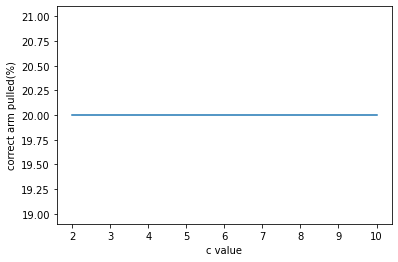

In [8]:
keys, values = correct_arms_pulled_ucb.keys(), correct_arms_pulled_ucb.values()
plt.plot(keys, values)
plt.xlabel("c value")
plt.ylabel("correct arm pulled(%)")
plt.savefig("ucb_c-vs-correct_arm_pulled.jpg", dpi=500)

In [9]:
with open('ucb_regret.pkl', 'wb') as f:
    pickle.dump(expected_regret_cumsum_values_ucb, f)

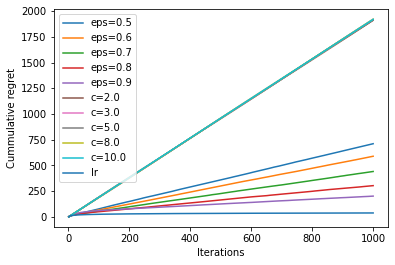

In [10]:
for key, value in expected_regret_cumsum_values.items():
    plt.plot(np.arange(1, num_iterations+1), value, label="eps="+str(key))
    
for key, value in expected_regret_cumsum_values_ucb.items():
    plt.plot(np.arange(1, num_iterations+1), value, label="c="+str(key))

plt.plot(np.arange(1, num_iterations+1), expected_lai_robbins_values[0.5], label="lr")
    
    
plt.xlabel("Iterations")
plt.ylabel("Cummulative regret")
plt.legend()
plt.savefig("eps_greedy-vs-ucb-vs-lai_robbins.jpg", dpi=500)